In [ ]:
!pip install torch-dreams

In [403]:
import matplotlib.pyplot as plt
import torchvision.models as models
from torch_dreams.dreamer import dreamer

import cv2 
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn

from torch_dreams.image_transforms import resize_4d_tensor_by_size
# https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [ ]:
!wget -O castle.jpg "https://www.brides.com/thmb/ituJ-qXMRfMhH0AUUWSqrbxunIA=/3744x2808/smart/filters:no_upscale()/__opt__aboutcom__coeus__resources__content_migration__brides__proteus__5af9c06d368ea641e4c3a24d__11-75c2514d4c5c4dca921c0f35f2621c86.jpeg"
# !wget -O doge.jpg "https://pbs.twimg.com/profile_images/1033774361595936768/x9bT_0S_.jpg"

## Preparing the image

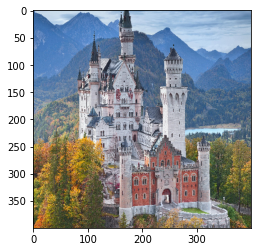

In [580]:
im = cv2.cvtColor(cv2.imread('castle.jpg'), cv2.COLOR_BGR2RGB)/255.
im = cv2.resize(im, (400,400))  ## resize for faster computations 
height , width , channels = im.shape
plt.imshow(im)
plt.show()


In [581]:
image_tensor = torch.tensor(im).permute(-1,0,1).unsqueeze(0)
t = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

image_tensor_transformed = t(image_tensor)

# defining a custom loss 

It aims to compare the outputs of a model's layer(s) w.r.t another set of outputs which was stored after feeding an input image to the model


In [582]:
class SnapshotCosineSimilarity(nn.Module):
    def __init__(self, ideal_layer_outputs, sigma = 1.):
        super().__init__()
        ## outputs of certain layers saved after a forward pass 
        self.ideal_layer_outputs = [out * sigma for out in ideal_layer_outputs]
        
    
    def cosine_dissimilarity(self,x,y, eps = 1e-6):
        
        numerator = (x*y).sum() 
        denominator = torch.sqrt((y**2).sum()) + eps

    
        cossim = numerator/denominator
        cossim = torch.maximum(torch.tensor(0.1).cuda(), cossim)
        loss = -(cossim*numerator)
        return loss

    def loss(self, x,y):
        loss = self.cosine_dissimilarity(x,y) #+ torch.square(x - y).mean()
        return loss

    def forward(self,layer_outputs):
        assert len(layer_outputs) == len(self.ideal_layer_outputs)
        loss = 0.
        for i  in range(len(layer_outputs)):
        
            if layer_outputs[i].shape  ==  self.ideal_layer_outputs[i].shape:
                l  = self.loss(layer_outputs[i] ,self.ideal_layer_outputs[i])
                loss += l
            else:
                ## resizing might be necessary if the input image itself gets resized 
                outs_resized = resize_4d_tensor_by_size(
                    x = layer_outputs[i].unsqueeze(0), 
                    height = self.ideal_layer_outputs[i].shape[-2],
                    width = self.ideal_layer_outputs[i].shape[-1]
                )
                l  =  self.loss(outs_resized.squeeze(0) , self.ideal_layer_outputs[i])
                loss += l
        # print(loss)
        return loss 

# Experiment 1: on googlenet 

In [583]:
model = models.googlenet(pretrained=True)

dreamy_boi = dreamer(model, device = 'cuda', quiet= False)

# list(dict(model.named_children()).keys())  -> in case you want to view all the layer names :)
layers_to_watch = [
                model.inception3a,
                model.inception4c,
                model.inception4d,
                model.inception4e,
                model.inception5a
]

In [584]:
img_params = []

for layer in layers_to_watch:

    # Capture and store the outputs of the layers mentioned in arg layers
    snapshot = dreamy_boi.get_snapshot(
        layers = [layer],
        input_tensor = image_tensor_transformed
    )

    # define loss 
    snap_loss = SnapshotCosineSimilarity(ideal_layer_outputs = snapshot)

    # render with custom loss
    img_param = dreamy_boi.render(
        layers= [layer],
        custom_func= snap_loss,
        iters = 200,
        height= height,
        width= width,
        weight_decay= 1e-3,
        lr = 9e-3,
        scale_min= 0.4,
        rotate_degrees= 10
    )
    img_params.append(img_param)


100%|██████████| 200/200 [00:05<00:00, 36.81it/s]


In [585]:
layer_names = [
                "inception3a",
                "inception4c",
                "inception4d",
                "inception4e",
                "inception5a"
]

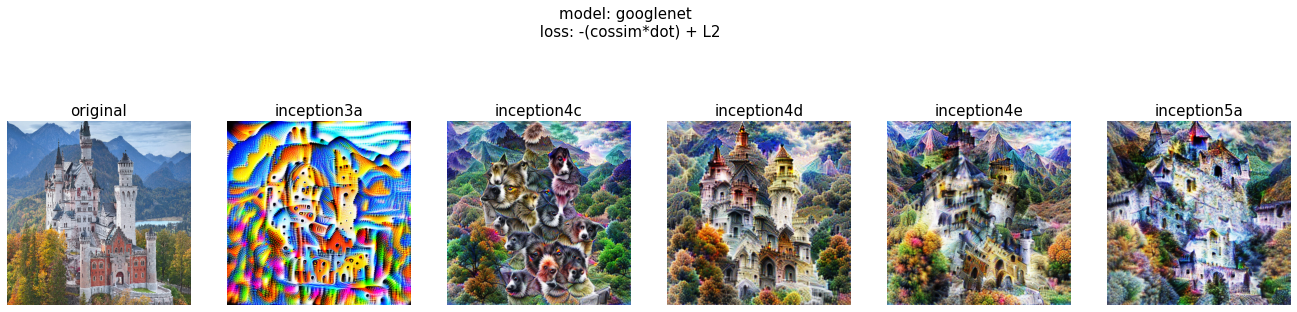

In [586]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize = (23,6))
fig.suptitle('model: googlenet \n loss: -(cossim*dot) + L2',fontsize = 15)

ax.flat[0].imshow(im)    
ax.flat[0].set_title('original', fontsize = 15)
ax.flat[0].axis('off')

for i in range(1,6):
    ax.flat[i].imshow(img_params[i-1])
    ax.flat[i].set_title(layer_names[i-1],fontsize = 15)
    ax.flat[i].axis('off')



## Running on adversarial examples

In [ ]:
!pip install deeprobust

In [587]:
from deeprobust.image.attack.pgd import PGD
from deeprobust.image.config import attack_params

adversary = PGD(model, 'cuda')
adversarial_image = adversary.generate(image = image_tensor_transformed, label = torch.tensor([483.]), print_process = False, epsilon = 0.3)

print(F.mse_loss(adversarial_image.cpu(), image_tensor_transformed))

tensor(0.3759, dtype=torch.float64, grad_fn=<MseLossBackward>)


In [588]:
print('pred on original: ', torch.argmax(model(image_tensor_transformed.cuda().float())).item())
print('pred on adv: ',torch.argmax(model(adversarial_image.cuda().float())).item())

pred on original:  483
pred on adv:  741


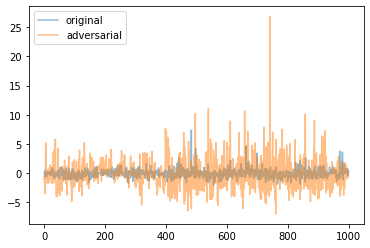

In [589]:
plt.plot(model(image_tensor_transformed.cuda().float())[0].cpu().detach(), label = 'original', alpha = 0.5)
plt.plot(model(adversarial_image.cuda().float())[0].cpu().detach(), label = 'adversarial', alpha = 0.5)
plt.legend()
plt.show()

In [590]:
img_params_adv = []

for layer in layers_to_watch:

    # Capture and store the outputs of the layers mentioned in arg layers
    snapshot = dreamy_boi.get_snapshot(
        layers = [layer],
        input_tensor = adversarial_image   ## using adv example here 
    )

    # define loss 
    snap_loss = SnapshotCosineSimilarity(ideal_layer_outputs = snapshot)

    # render with custom loss
    img_param = dreamy_boi.render(
        layers= [layer],
        custom_func= snap_loss,
        iters = 200,
        height= height,
        width= width,
        weight_decay= 1e-3,
        lr = 9e-3,
        scale_min= 0.4,
        rotate_degrees= 10
    )
    img_params_adv.append(img_param)


100%|██████████| 200/200 [00:05<00:00, 38.22it/s]


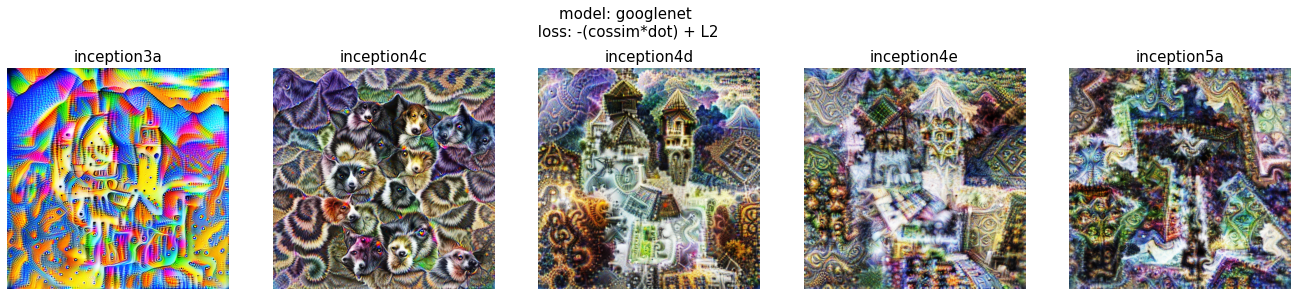

In [591]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize = (23,5))
fig.suptitle('model: googlenet \n loss: -(cossim*dot) + L2 \n',fontsize = 15)


for i in range(5):
    ax.flat[i].imshow(img_params_adv[i])
    ax.flat[i].set_title(layer_names[i],fontsize = 15)
    ax.flat[i].axis('off')

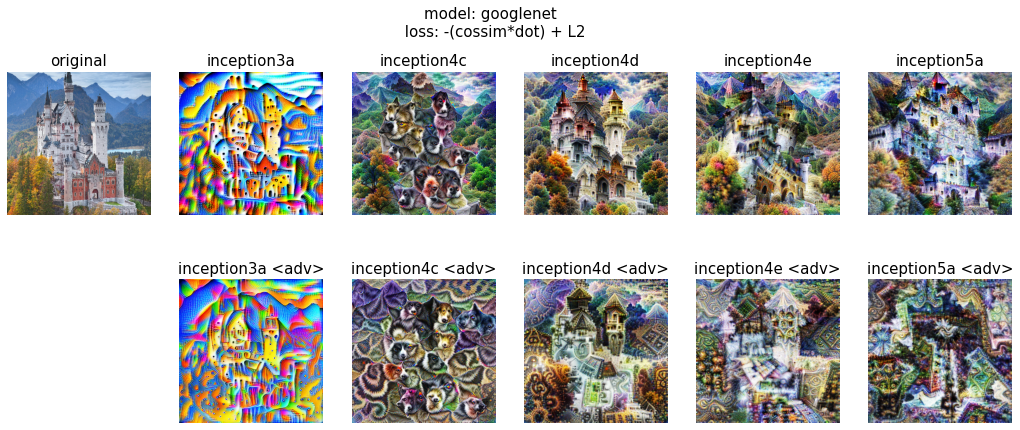

In [594]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize = (18,7))
fig.suptitle('model: googlenet \n loss: -(cossim*dot) + L2',fontsize = 15)

ax.flat[0].imshow(im)    
ax.flat[0].set_title('original', fontsize = 15)
ax.flat[0].axis('off')

for i in range(1,6):
    ax.flat[i].imshow(img_params[i-1])
    ax.flat[i].set_title(layer_names[i-1],fontsize = 15)
    ax.flat[i].axis('off')

fig.delaxes(ax.flat[6])

for i in range(7,12):
    ax.flat[i].imshow(img_params_adv[i-7])
    ax.flat[i].set_title(layer_names[i-7] + ' <adv>',fontsize = 15)

    ax.flat[i].axis('off')

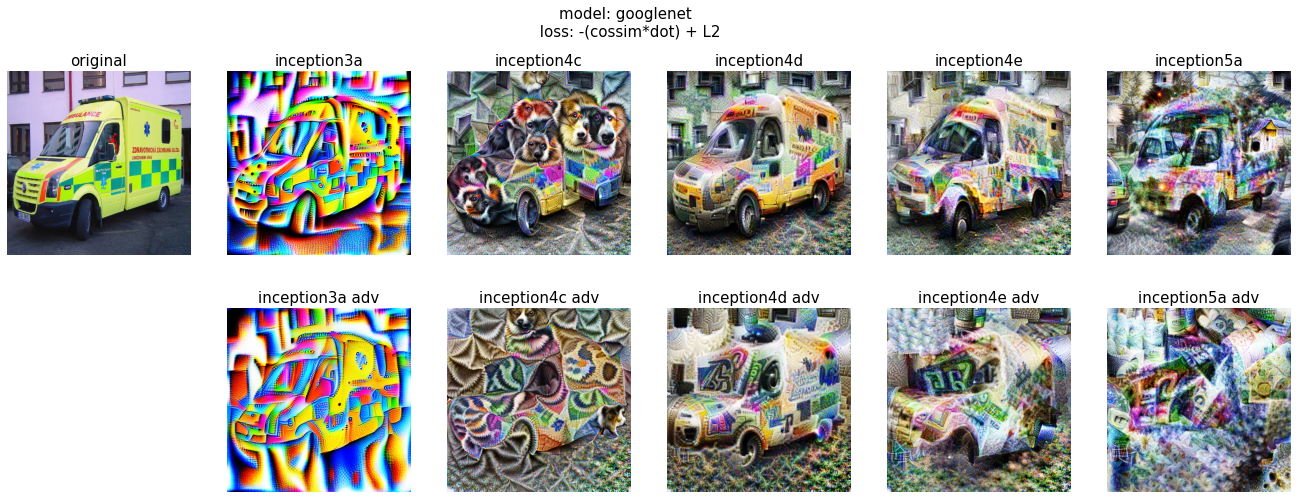

In [578]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize = (23,8))
fig.suptitle('model: googlenet \n loss: -(cossim*dot) + L2',fontsize = 15)

ax.flat[0].imshow(im)    
ax.flat[0].set_title('original', fontsize = 15)
ax.flat[0].axis('off')

for i in range(1,6):
    ax.flat[i].imshow(img_params[i-1])
    ax.flat[i].set_title(layer_names[i-1],fontsize = 15)
    ax.flat[i].axis('off')

fig.delaxes(ax.flat[6])

for i in range(7,12):
    ax.flat[i].imshow(img_params_adv[i-7])
    ax.flat[i].set_title(layer_names[i-7] + ' adv',fontsize = 15)

    ax.flat[i].axis('off')